<a href="https://colab.research.google.com/github/FrancescoMonaco/ArcEager/blob/main/LFN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations, Imports, Data Retrieval



In [ ]:
#@title Libraries install and imports
%%capture
!pip install nilearn
!pip install plotly
!pip install python-louvain

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#*** Libraries to manipulate fMRI data
from nilearn import datasets, plotting
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker
from nilearn.input_data import NiftiLabelsMasker
#*** Libraries for graphs
import networkx as nx
#*** Basic imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
import gc, os
from tqdm import tqdm
import scipy.stats as stats
import pickle
#*** Scaler for the data
from sklearn.preprocessing import StandardScaler
#*** Multiprocessing tools
import multiprocessing
from multiprocessing import Pool

#*** Import the python-greedy modularity package
import matplotlib.cm as cm
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities

In [ ]:
#@title Download graph-tool

%%capture
!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard
!pip install --force-reinstall nilearn


'\n%%capture\n!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list\n!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25\n!apt-get update\n!apt-get install python3-graph-tool python3-matplotlib python3-cairo\n!apt purge python3-cairo\n!apt install libcairo2-dev pkg-config python3-dev\n!pip install --force-reinstall pycairo\n!pip install zstandard\n!pip install --force-reinstall nilearn\n'

In [ ]:
#@title Imports from external py files
import requests
base_url = "raw.githubusercontent.com/FrancescoMonaco/LFN_Project/main"
files_to_download = ["graph_metrics.py", "findpartitionofbrain.py", "mri_to_graph.py", "graph_plotter.py", "motif_plotter.py"]
for file_name in files_to_download:
      file_url = f"{base_url}/{file_name}"
      !wget {file_url}

import nilearn

from graph_metrics import *
from mri_to_graph import *
from findpartitionofbrain import *
from graph_plotter import *
from motif_plotter import *

--2024-01-11 14:01:38--  http://raw.githubusercontent.com/FrancescoMonaco/LFN_Project/main/graph_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/FrancescoMonaco/LFN_Project/main/graph_metrics.py [following]
--2024-01-11 14:01:38--  https://raw.githubusercontent.com/FrancescoMonaco/LFN_Project/main/graph_metrics.py
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11564 (11K) [text/plain]
Saving to: ‘graph_metrics.py’

graph_metrics.py    100%[===================>]  11.29K  --.-KB/s    in 0s      

2024-01-11 14:01:38 (39.9 MB/s) - ‘graph_metrics.py’ saved [11564/11564]

URL transformed to HTT

In [ ]:
#@title Download precomputed data or original (original needs about 10 minutes of processing)
%%capture
prec = True # @param {type:"boolean"}
if prec:
  import requests
  import pickle
  base_url = "raw.githubusercontent.com/FrancescoMonaco/LFN_Project/main"
  files_to_download = ["Dataframes/adhd_data.pkl", "Dataframes/control_data.pkl", "Dataframes/bp_data.pkl", "Dataframes/schz_data.pkl"]

# Download each file
  for file_name in files_to_download:
      file_url = f"{base_url}/{file_name}"
      !wget {file_url}
  # Load dataframes with graphs using Pickle
  with open('/content/control_data.pkl', 'rb') as file:
      control_data = pickle.load(file)

  with open('/content/schz_data.pkl', 'rb') as file:
      schz_data = pickle.load(file)

  with open('/content/bp_data.pkl', 'rb') as file:
      bp_data = pickle.load(file)

  with open('/content/adhd_data.pkl', 'rb') as file:
      adhd_data = pickle.load(file)
else:
  # Load the brain atlas
  atlas = datasets.fetch_atlas_msdl()
  # Load the atlas image stored in 'maps'
  atlas_filename = atlas["maps"]
  # Load atlas data stored in 'labels'
  labels = atlas["labels"]

  # Load the dataset
  _, urls = datasets.fetch_ds000030_urls()

  selected_subjects = [
      'sub-10159', 'sub-10171', 'sub-10189', 'sub-10206', 'sub-10217',
      'sub-10292', 'sub-10524', 'sub-10316', 'sub-10940', 'sub-11156',
      'sub-10506', 'sub-10678', 'sub-10523', 'sub-10525', 'sub-10530',
      'sub-10674','sub-11122', 'sub-10680', 'sub-10686', 'sub-10696',
      'sub-50077', 'sub-50085', 'sub-50080', 'sub-50058', 'sub-50056',
      'sub-50054', 'sub-50055', 'sub-50053', 'sub-50051','sub-50052'
      'sub-50004', 'sub-50005', 'sub-50006', 'sub-50007', 'sub-50008',
      'sub-50010', 'sub-50013', 'sub-50014', 'sub-50015', 'sub-50016',
      'sub-60001', 'sub-60005', 'sub-60006', 'sub-60008', 'sub-60010',
      'sub-60011', 'sub-60012', 'sub-60014', 'sub-60015', 'sub-60016',
      'sub-60017','sub-60018','sub-60019','sub-60020','sub-60021',
      'sub-60022','sub-60028','sub-60033','sub-60036','sub-60037',
      'sub-70040','sub-70046','sub-70048','sub-70049','sub-70051',
      'sub-70052','sub-70055','sub-70057','sub-70058','sub-70061',
      'sub-70017', 'sub-70020', 'sub-70021', 'sub-70022', 'sub-70026',
      'sub-70029', 'sub-70033', 'sub-70034', 'sub-70083', 'sub-70086'
  ]

  filtered_urls = [url for url in urls if any(subject in url for subject in selected_subjects)]

  # Define exclusion patterns to exclude unwanted data
  exclusion_patterns = [
      "*/freesurfer/*"
      "*derivatives/task*",
      "*task_group*",
      "*/anat/*",
      "*group*",
      "*phenotype*",
      "*mriqc*",
      "*parameter_plots*",
      "*physio_plots*",
      "*space-fsaverage*",
      "*space-T1w*",
      "*dwi*",
      "*beh*",
      "*task-bart*",
      "*task-pamenc*",
      "*task-pamret*",
      "*task-scap*",
      "*task-task*",
      "*task-stopsignal*",
      "*task-bht*"
  ]

  # Apply the filters to select subjects and exclude unwanted data
  urls = datasets.select_from_index(
      filtered_urls, exclusion_filters=exclusion_patterns
  )

  try:
      # Fetch the selected subjects' data
      data_dir, _ = datasets.fetch_openneuro_dataset(urls=urls)
  except Exception as e:
      print(f"Finished, except: {e}")

In [ ]:
#@title Variables for data retrieval and manipulation
if not prec:
  base_path = "/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/"

  # Dataframes
  cols = ['data', 'confounds', 'graph', 'nodes', 'edges']
  control_data = pd.DataFrame(columns=cols)
  schz_data = pd.DataFrame(columns=cols)
  bp_data = pd.DataFrame(columns=cols)
  adhd_data = pd.DataFrame(columns=cols)

  # Visit each subject's folder
  for subject_folder in os.scandir(base_path):
      if subject_folder.is_dir():
          condition = subject_folder.name[4]  # Extract the condition from the subject id

          # Variables
          data_path = None
          confounds_data = None

          # Retrieve the data

          func_path = os.path.join(subject_folder.path, "func")
          for func_file in os.scandir(func_path):
            # Find the confounds variables file
                if func_file.name.endswith(".tsv"):
                      confounds_data = pd.read_csv(func_file.path, sep='\t')
            # Find the resting state fmri
                if func_file.name.endswith("preproc.nii.gz"):
                      data_path = func_file.path

          # Add data to the respective dataframe
          if condition == "1":
              control_data.loc[len(control_data)] = [data_path, confounds_data, None, None, None]
          elif condition == "5":
              schz_data.loc[len(schz_data)] = [data_path, confounds_data, None, None, None]
          elif condition == "6":
              bp_data.loc[len(bp_data)] = [data_path, confounds_data, None, None, None]
          elif condition == "7":
              adhd_data.loc[len(adhd_data)] = [data_path, confounds_data, None, None, None]

# MRI to Graph
This converts fMRIs to graphs using a data-adaptive algorithm

In [ ]:
#@title Load brain atlas
import nibabel as nib
schaefer_1000 = datasets.fetch_atlas_schaefer_2018(n_rois=1000, yeo_networks=7, resolution_mm=1, verbose=1)

# Load the atlas data
atlas_img = nib.load(schaefer_1000.maps)

# ROIs coordinates
coords = np.vstack(np.where(atlas_img.get_fdata() > 0)).T


Dataset created in /root/nilearn_data/schaefer_2018



 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


In [ ]:
#@title Transform loop
dataframes = [control_data, schz_data, bp_data, adhd_data]

# Create processors for the data
if not prec:
    # Timeseries extractor
  spheres_masker = NiftiLabelsMasker(
      labels_img=schaefer_1000.maps,
      smoothing_fwhm=1,
      detrend=True,
      standardize="zscore_sample",
      t_r=None
  )

  threshold = 0.85 # @param {type:"slider", min:0, max:1, step:0.01}

  # Wrapper for the dataframes
  dataframes = [control_data, schz_data, bp_data, adhd_data]
  conditions = ["Control", "Schizophrenia", "Bipolar", "ADHD"]
  num_processes = multiprocessing.cpu_count()  # Number of available CPU cores

  # Execution
  with Pool(processes=num_processes) as pool:
      processed_data = pool.starmap(
          process_dataframe,
          [(dataframe, condition, spheres_masker, threshold) for dataframe, condition in zip(dataframes, conditions)]
      )
  for df, results in zip(dataframes, processed_data):
      for result in results:
          row_name, G, num_nodes, num_edges, corr_matr, num_nodes_per_component = result
          df.at[row_name, 'graph'] = G
          df.at[row_name, 'nodes'] = num_nodes
          df.at[row_name, 'edges'] = num_edges
          #df.at[row_name, 'matrix'] =  tuple(corr_matr)
         # df.at[row_name, 'nodes_per_component'] =  num_nodes_per_component

In [ ]:
#@title Compute mean number of nodes and edges
# Concatenate all dataframes into one
combined_data = pd.concat(dataframes)

# Calculate the mean number of nodes and edges
mean_nodes = combined_data['nodes'].mean()
mean_edges = combined_data['edges'].mean()

print(f"Mean Nodes: {mean_nodes}")
print(f"Mean Edges: {mean_edges}")

# Run garbage collection
del mean_nodes, mean_edges, combined_data
gc.collect()

Mean Nodes: 767.8552631578947
Mean Edges: 4246.0


7

# Graph Analysis
Local and global features, significance w.r.t. random graphs, analysis on the features

## Metrics on the graph

In [ ]:
#@title Create random graphs using the same degree frequencies found in the original ones
dataframes = [control_data, schz_data, bp_data, adhd_data]
conditions = ["Control", "Schizophrenia", "Bipolar", "ADHD"]

rand_grp = pd.DataFrame(columns=['graph'])

for dataframe, condition in zip(dataframes,conditions):
  for original_graph in dataframe['graph']:
    # Get the degree sequence
      degree_sequence = [degree for _, degree in original_graph.degree()]
    # Generate multiple random graphs based on the same degree sequence
      random_graph = nx.Graph(nx.configuration_model(degree_sequence, create_using=nx.Graph()))
    # Add the random graph to the DataFrame
      rand_grp = rand_grp.append({'graph':random_graph, 'edges':random_graph.number_of_edges(), 'nodes': random_graph.number_of_nodes()}, ignore_index=True)

In [ ]:
#@title Processing cycle to compute graph metrics
# Wrapper for the dataframes
dataframes = [control_data, schz_data, bp_data, adhd_data, rand_grp]
conditions = ["Control", "Schizophrenia", "Bipolar", "ADHD", "Random"]
num_processes = multiprocessing.cpu_count()  # Number of available CPU cores

# Execution
with Pool(processes=num_processes) as pool:
    processed_data = pool.starmap(
        process_graphs,
        [(dataframe, condition) for dataframe, condition in zip(dataframes, conditions)]
    )

for df, results in zip(dataframes, processed_data):
    for result in results:
        (row_name, m_closeness, m_betweenness, m_degree, avg_clust,
            top5_close, top5_betw,
            top5_deg, top5_clust,
            modularity, gbe,ass, tran,lc,top_nodes_modular_closeness,top5_modular_betweeness) = result

        df.at[row_name, 'closeness'] = m_closeness
        df.at[row_name, 'betweenness'] = m_betweenness
        df.at[row_name, 'degree'] = m_degree
        df.at[row_name, 'clustering'] = avg_clust
        df.at[row_name,'top5_close'] = top5_close
        df.at[row_name,'top5_betw'] = top5_betw
        df.at[row_name,'top5_deg'] = top5_deg
        df.at[row_name,'top5_clust'] = top5_clust
        df.at[row_name, 'modularity'] = modularity
        df.at[row_name, 'global_efficiency'] = gbe
        df.at[row_name, 'assortativity'] = ass
        df.at[row_name, 'transitivity'] = tran
        df.at[row_name, 'local_efficiency'] = lc
        df.at[row_name, 'top5_modular_closeness'] = np.mean([top_nodes_modular_closeness[node] for node in top_nodes_modular_closeness])
        df.at[row_name, 'top5_modular_betweenness'] = np.mean([top5_modular_betweeness[node] for node in top5_modular_betweeness])


100%|██████████| 76/76 [12:35<00:00,  9.94s/it]


In [ ]:
#@title Print mean and std of the computed features across the various conditions
print_mean_std(dataframes, conditions)

+--------------------------+---------------------+--------------------+--------------------+--------------------+---------------------+
|          Metric          |       Control       |   Schizophrenia    |      Bipolar       |        ADHD        |       Random        |
+--------------------------+---------------------+--------------------+--------------------+--------------------+---------------------+
|        closeness         |   0.2009 ± 0.0140   |  0.1969 ± 0.0170   |  0.2083 ± 0.0177   |  0.2057 ± 0.0148   |   0.3284 ± 0.0102   |
|       betweenness        |   0.0047 ± 0.0005   |  0.0048 ± 0.0005   |  0.0046 ± 0.0005   |  0.0046 ± 0.0005   |   0.0027 ± 0.0001   |
|          degree          |  11.0967 ± 0.7213   |  11.4928 ± 1.2532  |  11.2157 ± 1.0959  |  10.8211 ± 0.8681  |  10.8349 ± 0.8877   |
|        clustering        |   0.3900 ± 0.0265   |  0.3937 ± 0.0297   |  0.3796 ± 0.0458   |  0.3810 ± 0.0435   |   0.0448 ± 0.0141   |
|        top5_close        |   0.2762 ± 0.0192  

###z-score, p-values computation
Interactive check of the significance of the features, probability of observing the data given the means of the group and the controls.

In [ ]:
#@title Features values
from scipy.stats import ttest_ind, zscore

def calculate_zscores(group, mean, std):
    return (group - mean) / std

feature = "top5_modular_closeness" # @param ["closeness", "betweenness", "degree", "top5_deg", "top5_close", "top5_betw", "clustering", "degree", "top5_clust", "modularity", "global_efficiency", "network_cost", "assortativity", "transitivity", "top5_modular_closeness", "top5_modular_betweenness"]

# Extract the feature of interest
control_global_efficiency = control_data[feature]
schz_global_efficiency = schz_data[feature]
bp_global_efficiency = bp_data[feature]
adhd_global_efficiency = adhd_data[feature]
rand_global_efficiency = rand_grp[feature]

schz_zscores_vs_random = calculate_zscores(schz_global_efficiency, rand_global_efficiency.mean(), rand_global_efficiency.std())
bp_zscores_vs_random = calculate_zscores(bp_global_efficiency, rand_global_efficiency.mean(), rand_global_efficiency.std())
adhd_zscores_vs_random = calculate_zscores(adhd_global_efficiency, rand_global_efficiency.mean(), rand_global_efficiency.std())
control_zscores_vs_random = calculate_zscores(control_global_efficiency, rand_global_efficiency.mean(), rand_global_efficiency.std())
rand_zscores = calculate_zscores(rand_global_efficiency, rand_global_efficiency.mean(), rand_global_efficiency.std())

# Perform t-tests between each group and the random group
t_stat_schz_vs_random, p_value_schz_vs_random = ttest_ind(schz_zscores_vs_random, rand_zscores, equal_var=False)
t_stat_bp_vs_random, p_value_bp_vs_random = ttest_ind(bp_zscores_vs_random, rand_zscores, equal_var=False)
t_stat_adhd_vs_random, p_value_adhd_vs_random = ttest_ind(adhd_zscores_vs_random, rand_zscores, equal_var=False)
t_stat_control_vs_random, p_value_control_vs_random = ttest_ind(control_zscores_vs_random, rand_zscores, equal_var=False)

# Print or use the p-values as needed
print("p-value Schizophrenia vs. Random: {:.3f}".format(p_value_schz_vs_random))
print("p-value Bipolar vs. Random: {:.3f}".format(p_value_bp_vs_random))
print("p-value ADHD vs. Random: {:.3f}".format(p_value_adhd_vs_random))
print("p-value Control vs. Random: {:.3f}".format(p_value_control_vs_random))

p-value Schizophrenia vs. Random: 0.000
p-value Bipolar vs. Random: 0.000
p-value ADHD vs. Random: 0.000
p-value Control vs. Random: 0.000


In [ ]:
#@title Print p-values of the t-tests
print_ttest_pval(dataframes, conditions)

+--------------------------+---------------+---------+--------+
|          Metric          | Schizophrenia | Bipolar |  ADHD  |
+--------------------------+---------------+---------+--------+
|        closeness         |    0.4367     | 0.1608  | 0.2953 |
|       betweenness        |    0.5535     | 0.5887  | 0.5237 |
|          degree          |    0.2345     | 0.6921  | 0.2816 |
|        clustering        |    0.6856     | 0.3943  | 0.4369 |
|        top5_close        |    0.7346     | 0.3510  | 0.7245 |
|        top5_betw         |    0.6105     | 0.7723  | 0.0434 |
|         top5_deg         |    0.0932     | 0.7018  | 0.9041 |
|        top5_clust        |      nan      |   nan   |  nan   |
|        modularity        |    0.8864     | 0.2979  | 0.0354 |
|    global_efficiency     |    0.5031     | 0.1451  | 0.4084 |
|      assortativity       |    0.2539     | 0.3556  | 0.1409 |
|       transitivity       |    0.3580     | 0.3561  | 0.3066 |
|     local_efficiency     |    0.9092  

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


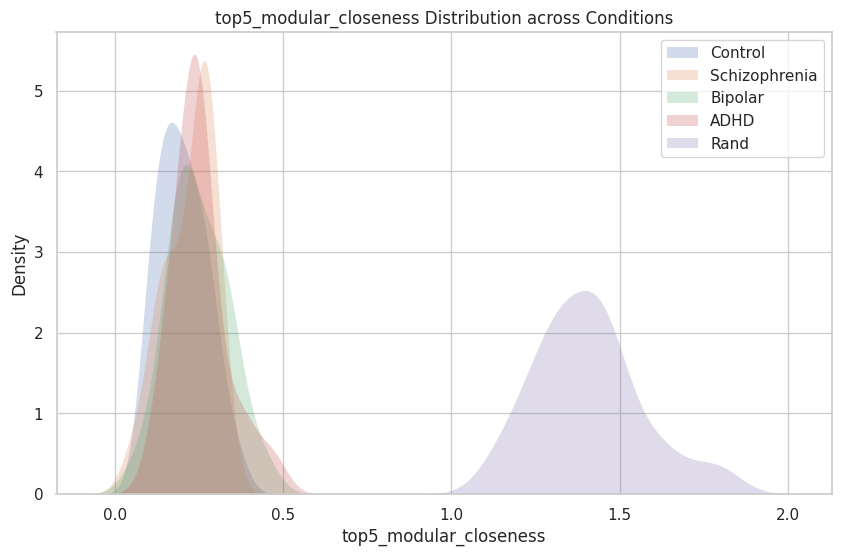

In [ ]:
#@title Probability distributions plotter
feature = "top5_modular_closeness" # @param ["global_efficiency", "closeness", "betweenness", "degree", "top5_deg", "top5_close", "top5_betw", "clustering", "degree", "top5_clust", "modularity", "global_efficiency", "network_cost", "assortativity", "transitivity", "top5_modular_closeness", "top5_modular_betweenness"]
# Set the style
sns.set(style="whitegrid")

# Plotting distributions with KDE and best-fit line
plt.figure(figsize=(10, 6))

# Control
sns.kdeplot(control_data[feature], label='Control', fill=True, common_norm=True, cut = 3,
    linewidth=0,)

# Schizophrenia
sns.kdeplot(schz_data[feature], label='Schizophrenia', fill=True, common_norm=True, cut = 3,
    linewidth=0,)

# Bipolar
sns.kdeplot(bp_data[feature], label='Bipolar', fill=True, common_norm=True, cut = 3,
    linewidth=0,)

# ADHD
sns.kdeplot(adhd_data[feature], label='ADHD', fill=True, common_norm=True, cut = 3,
    linewidth=0,)

sns.kdeplot(rand_grp[feature], label='Rand', fill=True, common_norm=True, cut = 3,
    linewidth=0,)

# Adding labels and title
plt.xlabel(feature)
plt.ylabel('Density')
plt.title(feature + ' Distribution across Conditions')

# Adding legend
plt.legend()

# Show the plot
plt.show()


#Brain Subsets Analysis
Local and global features on the modules

In [ ]:
#@title Compute communities

dataframes = [control_data, schz_data, bp_data, adhd_data, rand_grp]
conditions = ["Control", "Schizophrenia", "Bipolar", "ADHD", "Random"]

# Process the communities and the metrics related
with Pool(processes=num_processes) as pool:
    processed_data = pool.starmap(
        compute_communities,
        [(dataframe, condition) for dataframe, condition in zip(dataframes, conditions)]
    )

# Store communities and community metrics
for df, results in zip(dataframes, processed_data):
    df.loc[:,'communities'] = 5
    df['communities'] = df['communities'].astype(object)
    for result in results:

        (row_name, community,lc,lb) = result
        df.at[row_name, 'communities'] = community

        #df.at[row_name, 'communities_closeness'] = lc
        #df.at[row_name, 'communities_betweenness'] = lb

In [ ]:
#@title Plot the communities of a graph
condition = "Control" # @param ["Control", "Schizophrenia", "Bipolar", "ADHD"]
if condition == "Control": df_idx = 0
elif condition == "Schizophrenia": df_idx = 1
elif condition == "Bipolar": df_idx = 2
else: df_idx = 3

sample_number = 5 # @param {type:"slider", min:0, max:9, step:1}
sample_subject = dataframes[df_idx].iloc[sample_number]
communities = list(sample_subject['communities'])
sample_graph = sample_subject['graph']

# Create a dictionary to store node-community assignments
node_community_dict = {node: i for i, comm in enumerate(communities) for node in comm}

# Create a list of community assignments for each node
node_community = [node_community_dict[node] for node in sample_graph.nodes()]

fig = community_plot(sample_graph, node_community)
fig = graph_plot(sample_graph)

#Motifs
Find the main motifs of a brain network

In [ ]:
#@title Print top 3 motifs
dataframes = [control_data, schz_data, bp_data, adhd_data, rand_grp]
condition = "Random" # @param ["Control", "Schizophrenia", "Bipolar", "ADHD", "Random"]
k = 4 # @param {type:"integer"}
if condition == "Control": df_idx = 0
elif condition == "Schizophrenia": df_idx = 1
elif condition == "Bipolar": df_idx = 2
elif condition== "ADHD": df_idx = 3
else: df_idx=4

working_df = dataframes[df_idx]
plt = compute_plot_top3_motifs(working_df, k)

#Save zone
Save the dataframes with the graphs and all the features computed

In [ ]:
#@title Save dataframes as csv?
save_data = True # @param {type:"boolean"}
if save_data:
      import pickle

      # Save dataframes with graphs using Pickle
      with open('/content/control_data.pkl', 'wb') as file:
          pickle.dump(control_data, file)

      with open('/content/schz_data.pkl', 'wb') as file:
          pickle.dump(schz_data, file)

      with open('/content/bp_data.pkl', 'wb') as file:
          pickle.dump(bp_data, file)

      with open('/content/adhd_data.pkl', 'wb') as file:
          pickle.dump(adhd_data, file)
      print('Dataframes saved!')

download_data = True # @param {type:"boolean"}
if download_data:
  from google.colab import files
  zip_file = '/content/dataframes.zip'
  !zip -r dataframes.zip /content/control_data.pkl /content/schz_data.pkl /content/bp_data.pkl /content/adhd_data.pkl
  files.download(zip_file)